## Statistická práce
### Data
Pro práci byla použita data hráčů hry osu! z [data.ppy.sh](https://data.ppy.sh/), konkrétně data sesbíraná k 5.6.2024 obsahující top 1000 hráčů herního módu osu!.

Neboť jsou data ve formátu sql, tak jsem z něj vyextrahoval data do formátu csv pomocí přiloženého skriptu convert.py.

Z celkového datasetu jsem vybral 3 soubory, ze kterých jsem čerpal data pro další výpočty:
- `osu_user_stats` - Obsahuje data o jednotlivých hráčích, kteří jsou v top 1000 na žebříčku. Zahrnuje rozličná data, pro nás bude důležité hlavně jejich user_id, přesnost, celkové skóre a pozice.
- `osu_beatmap_failtimes` - První dva sloupce určují ID herní mapy a typ ukončení hry (fail = hřáč na těchto míste prohrál; exit = hráč opustil herní mapu dobrovolně). Zbylé sloupce pak obsahují pouze počty ukončení hry na určité mapě v určitém procentu postupu.
- `osu_scores_high` - Obsahuje data o nejlepších výkonech (skóre) hráčů na určitých herních mapách. První tři sloupce obsahují ID skóre, mapy a hráče. Nás pak zajímá hlavně sloupec čtvrtý, který obsahuje vlastní hodnotu dosaženého skóre.

### Konfidenční interval přesnosti

Jako první úlohu jsem zjistil 95%-konfidenční inteval z přesnosti hráčů. Jako nulovou hypotézu jsem si zvolil, že průměrná přesnost je 95%.

Mean Accuracy: 0.944777422
95.0% Confidence Interval: (np.float64(0.9433021293680406), np.float64(0.9462527146319595))
t-Statistic: -6.946744748390379
p-Value: 6.730394019882624e-12
Rejected the null hypothesis - the average accuracy is not 95%.


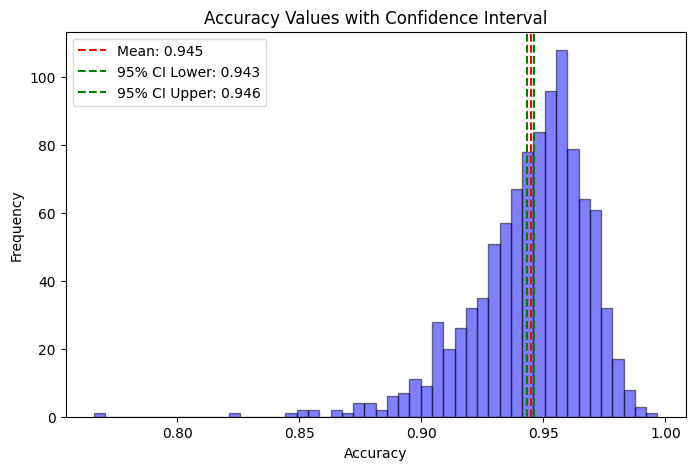

In [7]:
import csv
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

file_path = '2024_06_05_performance_osu_top_1000\osu_user_stats.txt'

total = 0
count = 0
accuracy_values = np.zeros(1000)

# Open the CSV file
with open(file_path, mode='r') as file:
    # Create a CSV reader object
    csv_reader = csv.reader(file)
    
    # Iterate through the rows in the CSV file
    i = 0
    for row in csv_reader:
        acc = float(row[7])
        accuracy_values[i] = np.float64(acc)
        total += acc
        count += 1
        i += 1

# Parameters
confidence_level = 0.95  # 95% confidence interval

# Calculate mean and standard error
mean_accuracy = np.mean(accuracy_values)
sem = stats.sem(accuracy_values)  # Standard error
df = len(accuracy_values)-1     # degrees of freedom

mu_0 = 0.95 # Hypothesized mean

# t-test statistic
t_statistic = (mean_accuracy - mu_0) / sem

# p-value (for two-tailed test)
p_value = 2 * (1 - stats.t.cdf(abs(t_statistic), df))

# Calculate the confidence interval
confidence_interval = stats.t.interval(confidence_level, df, loc=mean_accuracy, scale=sem)

print(f"Mean Accuracy: {mean_accuracy}")
print(f"{confidence_level*100}% Confidence Interval: {confidence_interval}")

print(f"t-Statistic: {t_statistic}")
print(f"p-Value: {p_value}")

# Decision based on confidence level
alpha = 0.05
if p_value <= alpha:
    print("Rejected the null hypothesis - the average accuracy is not 95%.")
else:
    print("Failed to reject the null hypothesis - the average accuracy is 95%.")


# Plotting
plt.figure(figsize=(8, 5))
plt.hist(accuracy_values, bins=50, alpha=0.5, color='blue', edgecolor='black')
plt.axvline(mean_accuracy, color='red', linestyle='--', label=f'Mean: {mean_accuracy:.3f}')
plt.axvline(confidence_interval[0], color='green', linestyle='--', label=f'{confidence_level*100:.0f}% CI Lower: {confidence_interval[0]:.3f}')
plt.axvline(confidence_interval[1], color='green', linestyle='--', label=f'{confidence_level*100:.0f}% CI Upper: {confidence_interval[1]:.3f}')

# Annotations and labels
plt.title('Accuracy Values with Confidence Interval')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.legend(loc='upper left')

# Show plot
plt.show()

Nulovou hypotézu se podařilo zamítnout, tedy celková průměrná přesnost není 95 procent.

### Distribuce failtimes

Z druhého souboru s daty můžeme vyčíst failtimes (procentuální postup v herní mapě, kdy hráč prohrál) přes mnoho map a hráčů.

Data ze souborů zpracujeme a můžeme použít chi-squared test pro otestování hypotézy, že data mají logaritmicko-normální rozdělení:

Most common fail percentage: 12
P-value: 0.0
Reject the null hypothesis: Data does not follow the Lognormal distribution.


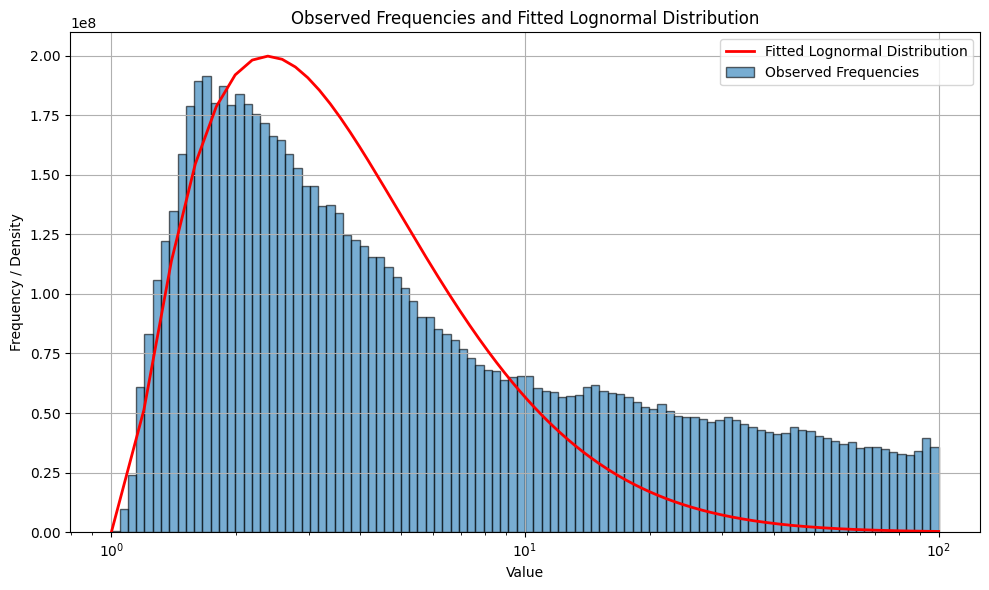

In [13]:
file_path_2 = '2024_06_05_performance_osu_top_1000\osu_beatmap_failtimes.txt'


fail_percentage = np.zeros(100)

with open(file_path_2, mode='r') as file:
    # Create a CSV reader object
    csv_reader = csv.reader(file)
    
    # Iterate through the rows in the CSV file
    for row in csv_reader:
        if row[1] == "fail":
            fail_percentage += np.array(row[2:102], dtype=int)


max_fail_perc = np.argmax(fail_percentage) + 1
print("Most common fail percentage: " + str(max_fail_perc))


fail_freq = fail_percentage

# Define bins for the histogram
bins = np.logspace(0, 2, 101)

# Estimate the parameters of the lognormal distribution
bin_centers = (bins[:-1] + bins[1:]) / 2

# Calculate the sample mean and variance of the log-transformed bin centers
log_bin_centers = np.log(bin_centers)

# Sample mean and variance of log-transformed data, weighted by frequencies
sample_mean_log = np.sum(log_bin_centers * fail_freq) / np.sum(fail_freq)
sample_var_log = np.sum(fail_freq * (log_bin_centers - sample_mean_log)**2) / np.sum(fail_freq)

# Estimate the parameters of the normal distribution
sigma = np.sqrt(sample_var_log)     # Standard deviation
mu = sample_mean_log                # Mean

# Define the lognormal distribution from mu and sigma
shape = sigma
scale = np.exp(mu)

# Calculate the expected frequencies for each bin
# Compute the PDF for the fitted lognormal distribution
expected_freq = stats.lognorm.pdf(bin_centers, shape, loc=1, scale=scale) * np.diff(bins) * np.sum(fail_freq)

# Normalize (to fix rounding error when passed to chisquare)
normalized_expected_freq = expected_freq * (np.sum(fail_freq) / np.sum(expected_freq))

# Perform the chi-square test
chi2_statistic, p_value = stats.chisquare(f_obs=fail_freq, f_exp=normalized_expected_freq)

print(f"P-value: {p_value}")

if p_value < 0.05:
    print("Reject the null hypothesis: Data does not follow the Lognormal distribution.")
else:
    print("Fail to reject the null hypothesis: Data may follow the Lognormal distribution.")


# Plot data agains lognormal plot
plt.figure(figsize=(10, 6))

# Observed frequencies as a bar plot
plt.bar(bins[:-1], fail_freq, width=np.diff(bins), align='edge', edgecolor='k', alpha=0.6, label='Observed Frequencies')

# Compute the PDF
x = np.linspace(min(bins), max(bins), 500)
pdf = stats.lognorm.pdf(x, shape, loc=1, scale=scale) 
pdf = pdf * (np.sum(fail_freq) / np.sum(pdf))


# Lognormal distribution as a line plot
plt.plot(x, pdf, 'r-', lw=2, label='Fitted Lognormal Distribution')

plt.xscale('log')
plt.title('Observed Frequencies and Fitted Lognormal Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency / Density')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Rozložení míst, kde hráči nejčastěji skončí při hraní mapy, tedy neodpovídá logaritmicko-normálnímu rozdělení.

### Srovnání dvou top hráčů

V této sekci porovnám dva hráče s podobným celkovým skóre z top žebříčku (hráč #2 a #4).

Využiji zde párového t-testu, jako nulovou hypotézu zvolím, že hráči mají stejný výkon přes všechny herní mapy. Alternativní je pak, že hráč #4 má lepší výkon.

In [5]:
import csv
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import ttest_rel

file_path = '2024_06_05_performance_osu_top_1000\osu_scores_high.txt'


firstPlayerID = 9269034
secondPlayerID = 10549880

firstMaps = []
secondMaps = []

firstScores = {}
secondScores = {}

# Open the CSV file
with open(file_path, mode='r') as file:
    # Create a CSV reader object
    csv_reader = csv.reader(x.replace('\0', '') for x in file)
    
    # Iterate through the rows in the CSV file
    for row in csv_reader:
        if int(row[2]) == firstPlayerID:
            firstMaps.append(int(row[1]))
            if int(row[1]) in firstScores:
                if firstScores[int(row[1])] < int(row[3]):
                    firstScores[int(row[1])] = int(row[3])
            else:
                firstScores[int(row[1])] = int(row[3])

        elif int(row[2]) == secondPlayerID:
            secondMaps.append(int(row[1]))
            if int(row[1]) in secondScores:
                if secondScores[int(row[1])] < int(row[3]):
                    secondScores[int(row[1])] = int(row[3])
            else:
                secondScores[int(row[1])] = int(row[3])


common_items = set(firstMaps) & set(secondMaps)

# Print the number of common items
print("Number of common items:", len(common_items))

firstTotal = 0
secondTotal = 0

firstCommonScores = []
secondCommonScores = []

for mapID in common_items:
    firstTotal += firstScores[mapID]
    firstCommonScores.append(firstScores[mapID])

    secondTotal += secondScores[mapID]
    secondCommonScores.append(secondScores[mapID])

    # print(str(mapID) + " : " + str(abs(firstScores[mapID] - secondScores[mapID])))
    

print("First total score: " + str(firstTotal))
print("Second total score: " + str(secondTotal))


# Load the data
data = {
    "Player 2 score": firstCommonScores,
    "Player 4 score": secondCommonScores
}

df = pd.DataFrame(data)

# Paired t-test
t_stat, p_value = ttest_rel(df["Player 4 score"], df["Player 2 score"], alternative='greater')

# Print the results
print(f"t-statistic: {t_stat}")
print(f"p-value: {p_value}")

# Determine if the null hypothesis was rejected
alpha = 0.05        # statistically significant
if p_value < alpha:
    print("Reject the null hypothesis: Player #4 performs much better than player #2.")
else:
    print("Fail to reject the null hypothesis: Player #4 does not perform much better than player #2.")

Number of common items: 989
First total score: 18475191509
Second total score: 18749376937
t-statistic: 0.23051679690459942
p-value: 0.4088689672304645
Fail to reject the null hypothesis: Player #4 does not perform much better than player #2.


Nulovou hypotézu se nám nepodařilo zamítnout, tedy 2. a 4. hráč mají podobný výkon přes všechny mapy.

Pokud ale za secondPlayerID dosadíme ID hráče, který je první na žebříčku (7562902), tak dostaneme:

>Number of common items: 1463  
First total score: 27972751828  
Second total score: 44874013912  
t-statistic: 12.054520254981117  
p-value: 2.849224475343422e-32  
Reject the null hypothesis: Player #1 performs much better than player #2. 


Tedy naše nulová hypotéza je zamítnuta a hráč #1 je mnohem lepší přes všechny herní mapy než hráč #2.